In [34]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

import torch.utils.data  as Data
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt

%matplotlib inline
# module loading settings
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/shuffle_new/miniconda3/envs/pro/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


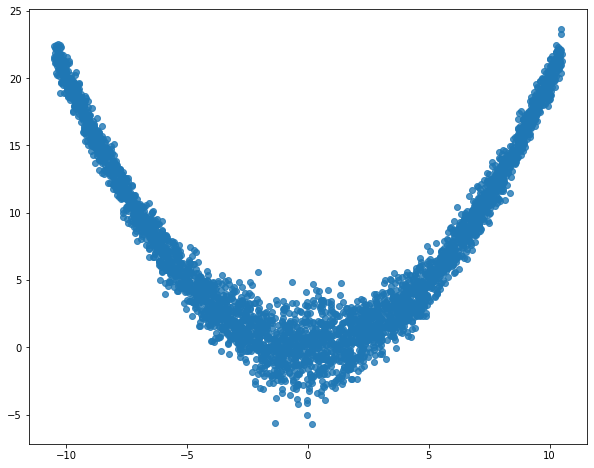

In [35]:
from sklearn.model_selection import train_test_split

# y_data: conditon
# x_data: dependent
def build_toy_dataset(n):
    np.random.seed(41)
    y_data = np.random.uniform(-10.5, 10.5, n)
    r_data = np.random.normal(size=n)  # random noise
#     x_data = np.sin(0.75 * y_data) * 7.0 + y_data * 0.5 + r_data * 1.0
    x_data = 0.2 * y_data ** 2 + r_data * 10 / (abs(y_data) + 5)
    x_data = x_data.reshape((n, 1))
    y_data = y_data.reshape((n, 1))
    
    return train_test_split(x_data, y_data, random_state=42)

n_observations = 5000  # number of data points

X_train, X_test, y_train, y_test = build_toy_dataset(n_observations)

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
sns.regplot(y_train, X_train, fit_reg=False);
plt.savefig('toydata.png')
plt.show()

simulated dataset / synthetic dataset

In [36]:
import torch
import torch.nn as nn

input: condition y

output: the conditional distribution of X given y. Specifically, we assume $P(X|Y=y)$ as $N(\mu, \sigma)$, the output of the neural network is $\mu$ and $\sigma$

In [37]:
class SimpleNormalNetwork(torch.nn.Module):
    def __init__(self, input_size=1, hidden_size=5):
        super(SimpleNormalNetwork, self).__init__()
        
        self.input_size = input_size
        self.hidden_size  = hidden_size
        
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, 2)
        self.softplus = torch.nn.Softplus()
        
    def forward(self, y):
        hidden = self.fc1(y)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        mean = output[:,0]
        std = self.softplus(output[:,1])
        return mean, std

In [38]:
from torch.distributions import Normal
model = SimpleNormalNetwork()

y = 3

neural network: N(0.44, 0.65)

x = 2, 5

log(f(2) * f(5)) = log(f(2)) + log(f(5))

In [39]:
def log_likelihood(x, y):
    if isinstance(y, np.ndarray):
        mean, std = model(torch.Tensor(y))
    else:
        mean, std = model(y)

    dist = Normal(mean.flatten(), std.flatten())
    log_likelihood_mean = dist.log_prob(torch.Tensor(x).flatten()).mean()
    return log_likelihood_mean

In [40]:
torch_dataset = Data.TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
BATCH_SIZE = 256
LR = 0.0002
EPOCH = 1000
loader = Data.DataLoader(dataset=torch_dataset,batch_size=BATCH_SIZE,shuffle=True)

In [41]:
optimizer_Adam = torch.optim.Adam(model.parameters(),lr = LR) #, betas = (0.9,0.99))
loss_record = []

In [42]:
def plot_on_test(epoch):
    test_mean, test_std = model(torch.Tensor(y_test))
    X_learned = np.random.normal(test_mean.detach().numpy(), test_std.detach().numpy())
    plt.figure()
    plt.scatter(y_test, X_learned, c='C0', label='learned')
    plt.scatter(y_test, X_test, c='C1', label='test')
    plt.legend()
    plt.savefig('plot_on_test_epoch_{}.jpg'.format(epoch))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


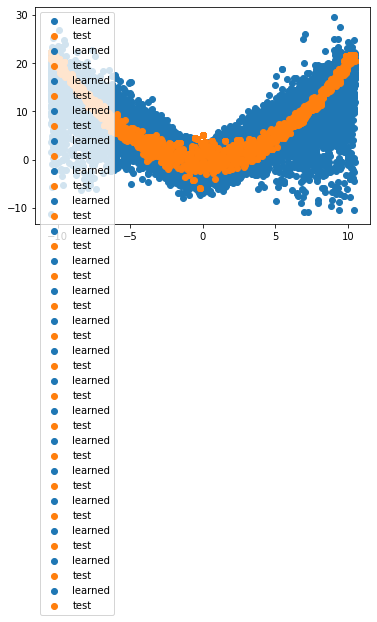

In [32]:
for epoch in range(EPOCH):
    if epoch % 10 == 0:
        print(epoch)
    for step ,(batch_x,batch_y) in enumerate(loader):
        loss = - log_likelihood(batch_x,batch_y)
        optimizer_Adam.zero_grad()
        loss.backward()
        optimizer_Adam.step()
        loss_record.append(loss.item())
    if epoch % 50 == 0:
        plot_on_test(epoch)